# Bet Against Beta #

In [22]:
# Import Libraries

# Data Management
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from portfolios_toolkit import calculate_analytics
from capm_toolkit import capm_regression

In [23]:
# Import Data
df_returns = pd.read_csv(r'..\additional_data\stocks_returns.csv')
df_returns = df_returns.rename(columns={'Unnamed: 0':'Date'})
df_returns.set_index('Date', inplace=True)
df_returns.index = pd.to_datetime(df_returns.index)
df_returns = df_returns.dropna(axis=1)

df_returns

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018915,-0.028576,-0.018998,0.000222,-0.004989,-0.018352,-0.035215,-0.000721,-0.014722,-0.010052,...,-0.013900,0.000000,-0.017166,-0.011416,-0.027743,-0.064259,-0.020527,0.036625,-0.014177,-0.006022
2015-01-06,-0.015700,0.000094,-0.004962,-0.011421,-0.020350,-0.023753,-0.019911,-0.008324,-0.019973,-0.011709,...,-0.017255,-0.001108,-0.021562,0.005306,-0.005330,-0.005898,-0.012351,-0.008513,-0.007231,-0.009804
2015-01-07,0.013184,0.013925,0.039621,0.008076,0.008190,0.010462,0.014920,0.008685,-0.002089,0.007747,...,0.016088,0.003045,0.028945,0.008598,0.010081,0.007857,0.032601,0.024566,0.025146,0.020432
2015-01-08,0.029534,0.037702,0.010404,0.020345,0.025135,0.017501,-0.014717,0.022681,0.024446,0.003522,...,0.019467,0.010722,0.011959,0.011532,0.016508,0.007517,0.017270,0.010561,0.021134,0.015282
2015-01-09,-0.007364,0.001072,-0.027736,-0.010563,-0.014922,-0.000731,-0.008566,-0.007188,-0.009054,-0.011270,...,-0.011519,-0.001368,0.012422,-0.012361,-0.001411,-0.019043,-0.001768,-0.014529,0.014508,0.001583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011083,0.011413,0.008985,0.003929,0.002683,0.014782,0.004355,0.007822,0.012494,0.013291,...,0.009663,0.006390,0.007575,0.007210,0.000940,0.005432,0.008480,0.004484,0.012187,0.002553
2024-12-26,-0.001986,0.003171,-0.004454,0.004434,0.004944,-0.000138,-0.000395,0.002594,-0.003159,-0.002203,...,0.001981,-0.003190,0.005952,-0.000440,0.000845,0.002705,0.007380,-0.000466,0.003559,0.004966
2024-12-27,-0.002137,-0.013331,-0.006663,-0.002432,-0.008208,-0.004919,-0.000593,-0.003539,-0.008999,-0.006305,...,-0.000630,-0.006410,-0.007079,-0.000587,-0.000094,-0.007966,-0.005678,-0.003549,-0.019799,-0.005574


In [24]:
# Get the important data for the Risk-Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index)
rfr.dropna(inplace = True)

# Get the important data for the S&P500
data_sp500 = pd.read_csv(r'..\additional_data\sp500.csv')
data_sp500.set_index('Date', inplace=True)
data_sp500.index = pd.to_datetime(data_sp500.index)
data_sp500 = data_sp500['sp_500']

### Calculate Betas ###

In [25]:
# Calculate the Market Excess Returns
market_excess_returns = (data_sp500 - rfr['risk_free_rate']).dropna()
market_excess_returns.name = 'market_excess_returns'

market_excess_returns

Date
2015-01-05   -0.018504
2015-01-06   -0.008988
2015-01-07    0.011508
2015-01-08    0.017674
2015-01-09   -0.008494
                ...   
2024-12-24    0.010855
2024-12-26   -0.000533
2024-12-27   -0.011246
2024-12-30   -0.010886
2024-12-31   -0.004421
Name: market_excess_returns, Length: 2497, dtype: float64

In [26]:
# Calculate Stocks Excess Returns
df_excess_returns = df_returns.sub(rfr['risk_free_rate'], axis=0)
df_excess_returns.dropna(inplace = True)

df_excess_returns

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018972,-0.028633,-0.019055,0.000166,-0.005045,-0.018409,-0.035271,-0.000778,-0.014779,-0.010109,...,-0.013956,-0.000057,-0.017223,-0.011472,-0.027800,-0.064315,-0.020584,0.036568,-0.014234,-0.006078
2015-01-06,-0.015755,0.000039,-0.005017,-0.011476,-0.020405,-0.023808,-0.019965,-0.008379,-0.020028,-0.011763,...,-0.017310,-0.001163,-0.021617,0.005252,-0.005385,-0.005953,-0.012405,-0.008568,-0.007285,-0.009858
2015-01-07,0.013130,0.013871,0.039567,0.008021,0.008135,0.010407,0.014866,0.008631,-0.002144,0.007693,...,0.016034,0.002990,0.028891,0.008544,0.010027,0.007802,0.032547,0.024512,0.025092,0.020378
2015-01-08,0.029478,0.037646,0.010348,0.020289,0.025079,0.017444,-0.014773,0.022624,0.024390,0.003466,...,0.019411,0.010666,0.011903,0.011476,0.016451,0.007461,0.017214,0.010504,0.021077,0.015225
2015-01-09,-0.007419,0.001017,-0.027791,-0.010618,-0.014977,-0.000786,-0.008621,-0.007243,-0.009109,-0.011325,...,-0.011574,-0.001423,0.012367,-0.012416,-0.001466,-0.019098,-0.001823,-0.014584,0.014453,0.001528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.010955,0.011285,0.008857,0.003801,0.002555,0.014654,0.004227,0.007695,0.012366,0.013163,...,0.009535,0.006262,0.007448,0.007082,0.000813,0.005304,0.008353,0.004356,0.012060,0.002426
2024-12-26,-0.002113,0.003043,-0.004582,0.004307,0.004817,-0.000265,-0.000522,0.002467,-0.003286,-0.002330,...,0.001854,-0.003317,0.005825,-0.000567,0.000718,0.002578,0.007253,-0.000593,0.003432,0.004839
2024-12-27,-0.002266,-0.013459,-0.006791,-0.002560,-0.008337,-0.005047,-0.000721,-0.003667,-0.009127,-0.006433,...,-0.000758,-0.006539,-0.007207,-0.000715,-0.000222,-0.008094,-0.005806,-0.003678,-0.019927,-0.005702


In [27]:
# Set the Window
window = len(df_excess_returns.loc['2015':'2020'])

# Create the Betas and Alpha + Residuals DataFrames for the whole time stamp
betas_dict = {}
capm_betas_dict = {}

# Loop to Obtain Betas and Alpha + Residuals
for ticker in df_excess_returns.columns:
    
    # Fit the WLS model
    model = capm_regression(
        df_excess_returns[ticker].loc['2015':'2020'], 
        market_excess_returns.loc['2015':'2020'],
        window=window,
        WLS=True
    )

    # Extract Alpha and Beta
    alpha = model.params.iloc[0]
    beta = model.params.iloc[1]

    # Store Beta
    betas_dict[ticker] = beta

# Create Beta Series
betas_series = pd.Series(betas_dict)
betas_series.name = 'beta'

betas_series.sort_values(ascending=False)

CZR    1.961553
APA    1.891440
MGM    1.747533
HAL    1.730422
DVN    1.705211
         ...   
SJM    0.412800
CPB    0.384091
KR     0.341595
NEM    0.335952
CLX    0.326932
Name: beta, Length: 391, dtype: float64

### First Strategy: Long Only Betas ###

In [28]:
long_beta_portfolio_weights = betas_series / betas_series.sum()
long_beta_portfolio_weights.name = 'weights'

long_beta_portfolio_weights

A       0.002414
AAPL    0.002903
ABBV    0.002024
ABT     0.002256
ADBE    0.002923
          ...   
XYL     0.002660
YUM     0.002115
ZBH     0.002352
ZBRA    0.003066
ZTS     0.002333
Name: weights, Length: 391, dtype: float64

In [29]:
# Portfolio Returns
long_portfolio_returns = df_returns.loc['2021':] @ long_beta_portfolio_weights
long_portfolio_returns.name = 'long_portfolio_returns'

long_portfolio_returns

Date
2021-01-04   -0.016054
2021-01-05    0.010587
2021-01-06    0.022610
2021-01-07    0.011152
2021-01-08    0.001735
                ...   
2024-12-24    0.008114
2024-12-26    0.001161
2024-12-27   -0.007220
2024-12-30   -0.009722
2024-12-31    0.001814
Name: long_portfolio_returns, Length: 1005, dtype: float64

In [30]:
long_portfolio_returns.mean()

0.0003866270810186905

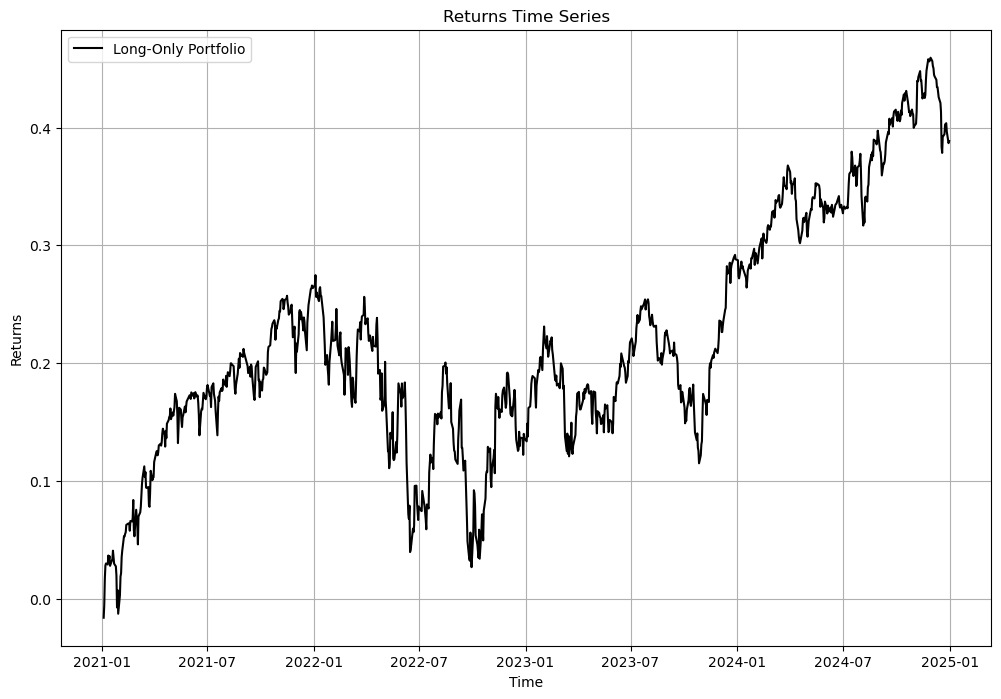

In [31]:
# Create Plot
plt.figure(figsize=(12, 8))
plt.plot(long_portfolio_returns.cumsum(), label='Long-Only Portfolio', color='black', alpha=1)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show() 

### Second Strategy: Betting Agains Beta ###

In [32]:
# Shrinking Betas
shrunk_betas = 0.6 * betas_series + 0.4

In [33]:
shrunk_betas.sort_values(ascending=False)

CZR    1.576932
APA    1.534864
MGM    1.448520
HAL    1.438253
DVN    1.423126
         ...   
SJM    0.647680
CPB    0.630455
KR     0.604957
NEM    0.601571
CLX    0.596159
Name: beta, Length: 391, dtype: float64

In [34]:
# Fist, calculate Ranks
ranks = shrunk_betas.rank()
median_rank = ranks.median()

In [35]:
# Second: define the groups
low_beta = ranks[ranks < median_rank]
high_beta = ranks[ranks >= median_rank]

In [36]:
# Non-scaled weights
z_bar = ranks.mean()

w_low = (z_bar - low_beta).clip(lower=0)
w_low = w_low / w_low.sum()

w_high = (high_beta - z_bar).clip(lower=0)
w_high = w_high / w_high.sum()

In [37]:
w_low

A       0.001413
ABBV    0.005861
ABT     0.003401
ADM     0.002983
AEE     0.007378
          ...   
WST     0.007326
XEL     0.008425
YUM     0.004919
ZBH     0.002250
ZTS     0.002459
Name: beta, Length: 195, dtype: float64

In [38]:
w_high

AAPL    0.004657
ADBE    0.004814
ADI     0.006122
ADP     0.001727
ADSK    0.006698
          ...   
WY      0.008739
WYNN    0.009628
XOM     0.000733
XYL     0.001465
ZBRA    0.006227
Name: beta, Length: 196, dtype: float64

In [39]:
# Scale to make beta neutral
beta_low = (w_low * shrunk_betas[w_low.index]).sum()
beta_high = (w_high * shrunk_betas[w_high.index]).sum()

w_low_scaled = w_low / beta_low
w_high_scaled = w_high / beta_high

In [40]:
bab_portfolio_weights = pd.concat([w_low_scaled, -w_high_scaled])
bab_portfolio_weights.name = 'weights'

bab_portfolio_weights.sort_values(ascending=True)

CZR   -0.008475
APA   -0.008432
MGM   -0.008388
HAL   -0.008345
DVN   -0.008301
         ...   
SJM    0.011940
CPB    0.012002
KR     0.012065
NEM    0.012128
CLX    0.012190
Name: weights, Length: 391, dtype: float64

In [41]:
bab_portfolio_weights.sum().round(3)

0.364

In [42]:
# Portfolio Returns
bab_portfolio_returns = df_returns.loc['2021':] @ bab_portfolio_weights
bab_portfolio_returns.name = 'bab_portfolio_returns'

bab_portfolio_returns

Date
2021-01-04   -0.003050
2021-01-05   -0.013167
2021-01-06   -0.010316
2021-01-07   -0.012100
2021-01-08    0.006303
                ...   
2024-12-24   -0.001667
2024-12-26    0.000940
2024-12-27    0.001443
2024-12-30   -0.004218
2024-12-31    0.001169
Name: bab_portfolio_returns, Length: 1005, dtype: float64

In [43]:
bab_portfolio_returns.mean()

-0.00014213733997328528

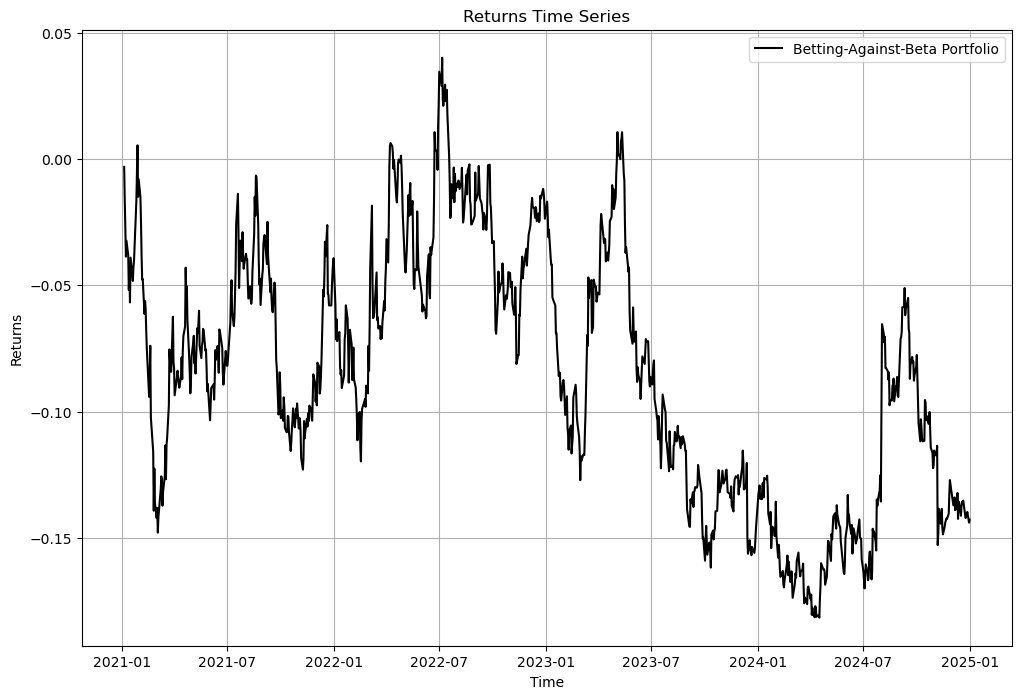

In [44]:
# Create Plot
plt.figure(figsize=(12, 8))
plt.plot(bab_portfolio_returns.cumsum(), label='Betting-Against-Beta Portfolio', color='black', alpha=1)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show() 

### Compare the Strategies ###

In [45]:
# Create DataFrame
strategies_df = pd.DataFrame(index = df_returns.loc['2021':].index)
strategies_df.index.name = 'date'
strategies_df['long_portfolio'] = long_portfolio_returns
strategies_df['bab_portfolio'] = bab_portfolio_returns

strategies_df

,long_portfolio,bab_portfolio
date,,
2021-01-04,-0.016054,-0.003050
2021-01-05,0.010587,-0.013167
2021-01-06,0.022610,-0.010316
2021-01-07,0.011152,-0.012100
2021-01-08,0.001735,0.006303
...,...,...
2024-12-24,0.008114,-0.001667
2024-12-26,0.001161,0.000940
2024-12-27,-0.007220,0.001443


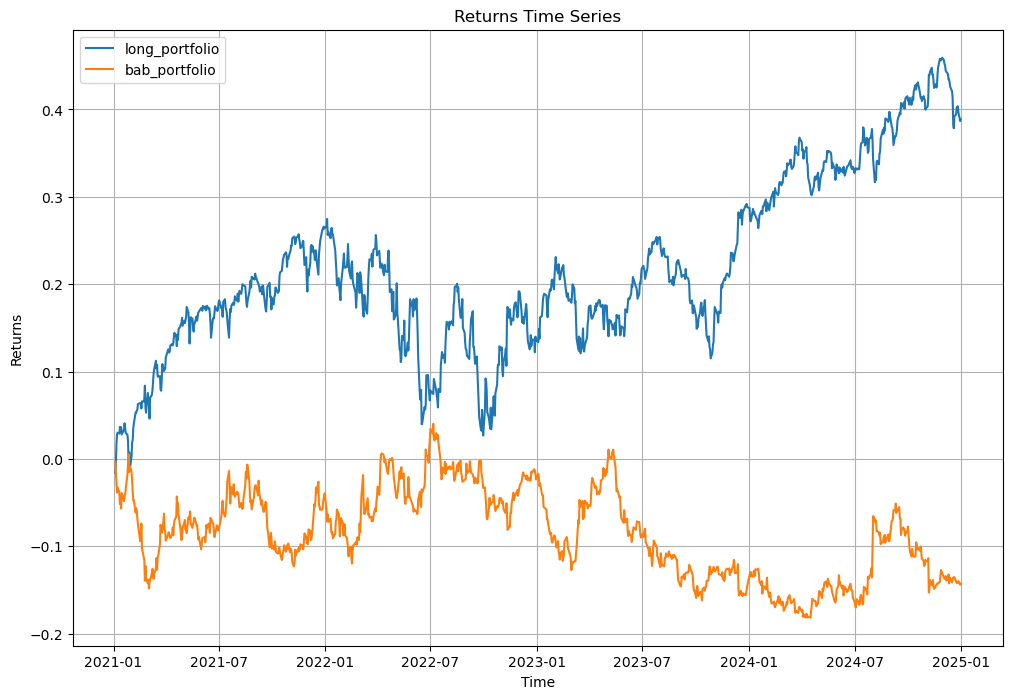

In [46]:
# Create Plot
plt.figure(figsize=(12, 8))
plt.plot(strategies_df.cumsum(), label=strategies_df.columns, alpha=1)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show() 

In [47]:
# Analytics
analytics = calculate_analytics(strategies_df)

analytics

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
long_portfolio,0.097430,0.170848,0.570272,-0.002478,-0.017122
bab_portfolio,-0.035819,0.132987,-0.269338,-0.002218,-0.013512


### Calculate the Portfolio Beta ###

In [48]:
# Create a DataFrame
regression_df = pd.DataFrame()
regression_df['portfolio_excess'] = bab_portfolio_returns - rfr['risk_free_rate'].loc['2021':]
regression_df['market_excess'] = market_excess_returns.loc['2021':]
regression_df.dropna(inplace = True)

regression_df

,portfolio_excess,market_excess
Date,,
2021-01-04,-0.003075,-0.014891
2021-01-05,-0.013194,0.007031
2021-01-06,-0.010345,0.005665
2021-01-07,-0.012130,0.014708
2021-01-08,0.006272,0.005445
...,...,...
2024-12-24,-0.001794,0.010855
2024-12-26,0.000812,-0.000533
2024-12-27,0.001314,-0.011246


In [49]:
# Fit the WLS model
portfolio_model = capm_regression(
    regression_df['portfolio_excess'], 
    regression_df['market_excess'],
    window=len(regression_df),
    WLS=True
)

print(portfolio_model.summary())

                            WLS Regression Results                            
Dep. Variable:       portfolio_excess   R-squared:                       0.113
Model:                            WLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     126.4
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           1.10e-27
Time:                        20:12:06   Log-Likelihood:                 3433.0
No. Observations:                 998   AIC:                            -6862.
Df Residuals:                     996   BIC:                            -6852.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0001      0.000     -0.431

### Implementing Rebalancing ###

In [50]:
import pandas as pd

def betting_against_beta_weights(
    betas: pd.Series
) -> pd.Series:
    
    # Drop NANs
    betas = betas.dropna()

    # Shrinkage
    w_shrink = 0.6      # Adjust
    betas_shrunk = w_shrink * betas + (1 - w_shrink) * 1.0

    # Ranking Betas
    ranks = betas_shrunk.rank()
    z_bar = ranks.mean()
    median_rank = ranks.median()

    # Split using the Median
    low_beta = ranks[ranks < median_rank]
    high_beta = ranks[ranks >= median_rank]

    # Calculate Weights
    w_low = (z_bar - low_beta).clip(lower=0)
    w_high = (high_beta - z_bar).clip(lower=0)

    # Standardize Weights
    w_low /= w_low.sum()
    w_high /= w_high.sum()

    # Scale betas so each side has a beta close to 1
    beta_low = (w_low * betas_shrunk[w_low.index]).sum()
    beta_high = (w_high * betas_shrunk[w_high.index]).sum()

    # Standardize Again
    w_low_scaled = w_low / beta_low
    w_high_scaled = w_high / beta_high

    # Concat
    bab_weights = pd.concat([w_low_scaled, -w_high_scaled])

    return bab_weights

In [51]:
# Fortunately, we calculated the betas (with a 252-d history in the previous notebook)
rolling_betas = pd.read_csv(r'..\additional_data\capm_hbetas.csv')
rolling_betas.set_index('date', inplace=True)
rolling_betas.index = pd.to_datetime(rolling_betas.index)
rolling_betas = rolling_betas[df_returns.columns]

rolling_betas

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-06,1.176301,1.133289,1.058010,1.156647,1.024336,1.305756,1.003269,1.031325,0.981028,0.638070,...,0.871749,0.877046,1.495471,0.602850,1.052003,1.016422,1.014646,0.826543,1.390445,0.977090
2016-01-07,1.193156,1.143015,1.036626,1.169334,1.031649,1.304715,0.990524,1.051031,1.020542,0.623841,...,0.874787,0.905032,1.563648,0.584929,1.036887,0.984285,1.023391,0.868437,1.411466,0.993377
2016-01-08,1.190314,1.138944,1.045278,1.172662,1.029067,1.298027,0.983423,1.050029,1.019055,0.622087,...,0.871610,0.907200,1.571409,0.590714,1.042232,0.984814,1.023369,0.865855,1.407793,0.994786
2016-01-11,1.189920,1.139194,1.030539,1.175321,1.031982,1.301203,0.980886,1.051863,1.025842,0.621822,...,0.868730,0.909952,1.564201,0.590253,1.042387,0.986160,1.013334,0.857941,1.402901,0.989470
2016-01-12,1.182843,1.128042,1.039380,1.178552,1.026322,1.305151,1.002741,1.050205,1.015977,0.624735,...,0.868787,0.904158,1.563765,0.586747,1.047692,0.992892,1.018707,0.869009,1.407277,0.991648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.826902,0.940220,0.218952,0.180198,1.254651,1.649151,0.414834,0.403575,1.354866,0.059739,...,0.732666,0.597677,0.826117,-0.043086,0.193304,1.020948,0.446940,0.450725,1.323413,0.624581
2024-12-24,0.830074,0.943684,0.212140,0.174506,1.255907,1.644121,0.378599,0.404428,1.368011,0.063043,...,0.721240,0.597976,0.803671,-0.052638,0.178404,1.016170,0.446892,0.458844,1.311635,0.615601
2024-12-26,0.831497,0.949753,0.211042,0.169304,1.257324,1.640901,0.377761,0.415453,1.363333,0.063705,...,0.717578,0.600968,0.793068,-0.054717,0.176821,1.010780,0.444528,0.462765,1.311140,0.617970


In [52]:
def calculate_bab_weights(beta_df, rebalance_days=21):
    """
    Calcula pesos BAB con rebalanceo cada `rebalance_days` días,
    pero devuelve un DataFrame con frecuencia diaria,
    con pesos forward filled entre rebalanceos.

    Parámetros:
    - beta_df: DataFrame con betas diarios, columnas=activos, índice=fechas (diario).
    - rebalance_days: frecuencia de rebalanceo en días (default=21).

    Retorna:
    - DataFrame con pesos diarios, actualizados cada rebalance_days.
    """
    # Fechas para rebalancear
    rebalance_dates = beta_df.index[::rebalance_days]

    weights_list = []

    for date in rebalance_dates:
        betas_today = beta_df.loc[date]
        weights = betting_against_beta_weights(betas_today)
        weights.name = date
        weights_list.append(weights)

    # DataFrame con pesos sólo en fechas de rebalanceo
    bab_weights_rebalance = pd.DataFrame(weights_list)

    # Reindexamos al índice diario completo, dejando NaNs en días sin rebalanceo
    bab_weights_daily = bab_weights_rebalance.reindex(beta_df.index)

    # Forward fill para mantener pesos constantes entre rebalanceos
    bab_weights_daily = bab_weights_daily.ffill().fillna(0)

    # Reindexamos columnas igual que beta_df para tener consistencia
    bab_weights_daily = bab_weights_daily.reindex(columns=beta_df.columns).fillna(0)

    return bab_weights_daily


In [53]:
bab_monthly_weights = calculate_bab_weights(rolling_betas, rebalance_days=21)

bab_monthly_weights

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-01-06,-0.006230,-0.005114,-0.003347,-0.005718,-0.002278,-0.008136,-0.001255,-0.002464,-0.000093,0.010821,...,0.004379,0.004191,-0.008973,0.011384,-0.003068,-0.001906,-0.001813,0.006005,-0.008647,0.000313
2016-01-07,-0.006230,-0.005114,-0.003347,-0.005718,-0.002278,-0.008136,-0.001255,-0.002464,-0.000093,0.010821,...,0.004379,0.004191,-0.008973,0.011384,-0.003068,-0.001906,-0.001813,0.006005,-0.008647,0.000313
2016-01-08,-0.006230,-0.005114,-0.003347,-0.005718,-0.002278,-0.008136,-0.001255,-0.002464,-0.000093,0.010821,...,0.004379,0.004191,-0.008973,0.011384,-0.003068,-0.001906,-0.001813,0.006005,-0.008647,0.000313
2016-01-11,-0.006230,-0.005114,-0.003347,-0.005718,-0.002278,-0.008136,-0.001255,-0.002464,-0.000093,0.010821,...,0.004379,0.004191,-0.008973,0.011384,-0.003068,-0.001906,-0.001813,0.006005,-0.008647,0.000313
2016-01-12,-0.006230,-0.005114,-0.003347,-0.005718,-0.002278,-0.008136,-0.001255,-0.002464,-0.000093,0.010821,...,0.004379,0.004191,-0.008973,0.011384,-0.003068,-0.001906,-0.001813,0.006005,-0.008647,0.000313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,-0.002752,-0.004107,0.013140,0.014023,-0.006029,-0.007732,0.009512,0.009904,-0.007077,0.017063,...,-0.001398,0.004805,-0.002796,0.018632,0.013533,-0.004893,0.008041,0.007355,-0.006815,0.001471
2024-12-24,-0.002752,-0.004107,0.013140,0.014023,-0.006029,-0.007732,0.009512,0.009904,-0.007077,0.017063,...,-0.001398,0.004805,-0.002796,0.018632,0.013533,-0.004893,0.008041,0.007355,-0.006815,0.001471
2024-12-26,-0.002752,-0.004107,0.013140,0.014023,-0.006029,-0.007732,0.009512,0.009904,-0.007077,0.017063,...,-0.001398,0.004805,-0.002796,0.018632,0.013533,-0.004893,0.008041,0.007355,-0.006815,0.001471


In [54]:
bab_rebalancing_portfolio = (df_returns.loc[bab_monthly_weights.index] * bab_monthly_weights).sum(axis = 1)

bab_rebalancing_portfolio

date
2016-01-06    0.017470
2016-01-07    0.012203
2016-01-08    0.005909
2016-01-11    0.008454
2016-01-12   -0.002866
                ...   
2024-12-23   -0.002192
2024-12-24    0.001746
2024-12-26    0.001259
2024-12-27    0.002587
2024-12-30   -0.005032
Length: 2245, dtype: float64

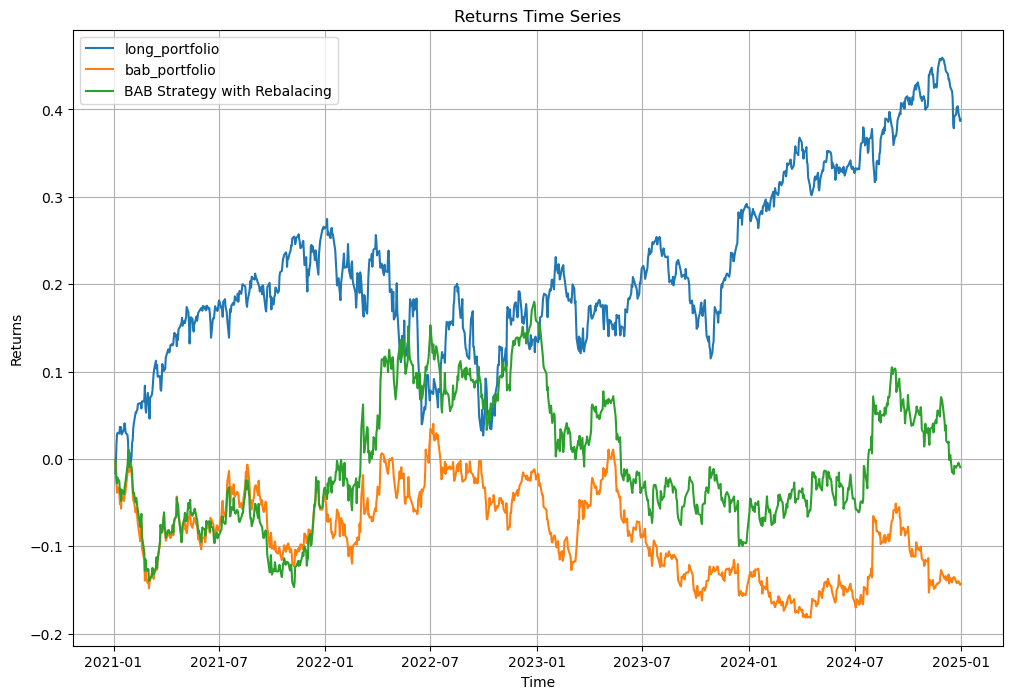

In [56]:
# Create Plot
plt.figure(figsize=(12, 8))
plt.plot(strategies_df.cumsum(), label=strategies_df.columns, alpha=1)
plt.plot(bab_rebalancing_portfolio.loc['2021':].cumsum(), label='BAB Strategy with Rebalacing', alpha=1)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show() 